In [1]:
%load_ext autoreload
%autoreload 2

# Calculate the b-factor on ECCO4v4

In [74]:
import numpy as np
import xarray as xr
from xgcm import Grid
import glob
import matplotlib.pyplot as plt
import gsw

In [25]:
rootdir = '/data2/project/ECCO4v4/'
# neutral density
localdir = 'GAMMAN/*/'
filename = 'GAMMAN_*.nc'
gamma = xr.open_mfdataset(rootdir+localdir+filename)#.drop(['XC','YC','Z','timestep','time_bnds'])
# temperature
localdir = 'nctiles_monthly/THETA/*/'
filename = 'THETA_*.nc'
theta = xr.open_mfdataset(rootdir+localdir+filename)#.drop(['XC','YC','Z','timestep','time_bnds'])
# salinity
localdir = 'nctiles_monthly/SALT/*/'
filename = 'SALT_*.nc'
salt = xr.open_mfdataset(rootdir+localdir+filename)#.drop(['XC','YC','Z','timestep','time_bnds'])

In [4]:
rootdir = '/home/gmacgilchrist/data/ECCO/'
filename = 'ECCO-GRID.nc'
grid = xr.open_dataset(rootdir+filename)

In [5]:
ds = xr.merge([gamma,theta,salt,grid]).rename({'tile':'face'}).isel(time=0)

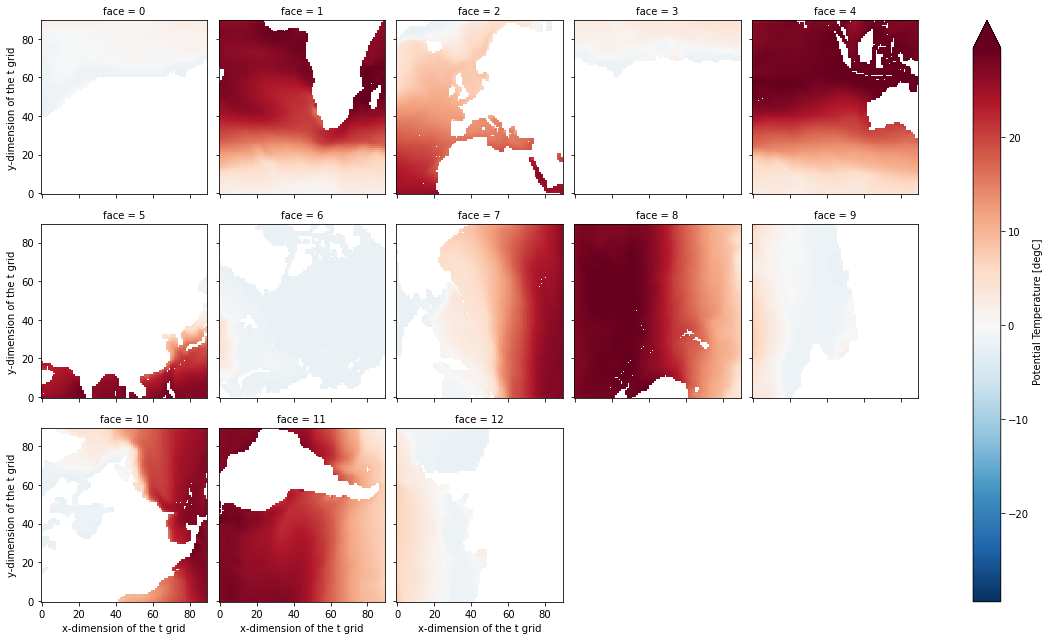

In [92]:
ds['THETA'].isel(k=0).plot(col='face', col_wrap=5, robust=True)

In [60]:
# define the connectivity between faces
face_connections = {'face':
                    {0: {'X':  ((12, 'Y', False), (3, 'X', False)),
                         'Y':  (None,             (1, 'Y', False))},
                     1: {'X':  ((11, 'Y', False), (4, 'X', False)),
                         'Y':  ((0, 'Y', False),  (2, 'Y', False))},
                     2: {'X':  ((10, 'Y', False), (5, 'X', False)),
                         'Y':  ((1, 'Y', False),  (6, 'X', False))},
                     3: {'X':  ((0, 'X', False),  (9, 'Y', False)),
                         'Y':  (None,             (4, 'Y', False))},
                     4: {'X':  ((1, 'X', False),  (8, 'Y', False)),
                         'Y':  ((3, 'Y', False),  (5, 'Y', False))},
                     5: {'X':  ((2, 'X', False),  (7, 'Y', False)),
                         'Y':  ((4, 'Y', False),  (6, 'Y', False))},
                     6: {'X':  ((2, 'Y', False),  (7, 'X', False)),
                         'Y':  ((5, 'Y', False),  (10, 'X', False))},
                     7: {'X':  ((6, 'X', False),  (8, 'X', False)),
                         'Y':  ((5, 'X', False),  (10, 'Y', False))},
                     8: {'X':  ((7, 'X', False),  (9, 'X', False)),
                         'Y':  ((4, 'X', False),  (11, 'Y', False))},
                     9: {'X':  ((8, 'X', False),  None),
                         'Y':  ((3, 'X', False),  (12, 'Y', False))},
                     10: {'X': ((6, 'Y', False),  (11, 'X', False)),
                          'Y': ((7, 'Y', False),  (2, 'X', False))},
                     11: {'X': ((10, 'X', False), (12, 'X', False)),
                          'Y': ((8, 'Y', False),  (1, 'X', False))},
                     12: {'X': ((11, 'X', False), None),
                          'Y': ((9, 'Y', False),  (0, 'X', False))}}}

# Define vertical metrics as negative, to account for descending coordinate
ds['drW'] = -1 * ds.hFacW * ds.drF #vertical cell size at u point
ds['drS'] = -1 * ds.hFacS * ds.drF #vertical cell size at v point
ds['drC'] = -1 * ds.hFacC * ds.drF #vertical cell size at tracer point

metrics = {
    ('X',): ['dxC', 'dxG'], # X distances
    ('Y',): ['dyC', 'dyG'], # Y distances
    ('Z',): ['drW', 'drS', 'drC'], # Z distances
    ('X', 'Y'): ['rA', 'rAz', 'rAs', 'rAw'] # Areas
}

# create the grid object
xgrid = Grid(ds, periodic=False, face_connections=face_connections, metrics=metrics)

In [61]:
def dhorz(ds,xgrid,var,mask=None):
    '''Take horizontal gradient of scalar field given by var.
    Return dictionary of horizontal gradient in each direction.'''
    
    if mask is not None:
        ds[var] = ds[var].where(ds[mask],np.nan)
    
    gx = xgrid.interp(ds[var], 'X')
    gy = xgrid.interp(ds[var], 'Y', boundary='fill')
    dg = xgrid.diff_2d_vector({'X':gx,'Y':gy},boundary='fill')
    
    D = xgrid.interp_2d_vector({'X':xgrid.get_metric(gx,'X'),'Y':xgrid.get_metric(gy,'Y')},boundary='fill')
    
    return {'X':dg['X']/D['X'],'Y':dg['Y']/D['Y']}

In [70]:
# Horizontal
dT = dhorz(ds,xgrid,var='THETA',mask='maskC')
dS = dhorz(ds,xgrid,var='SALT',mask='maskC')
dg = dhorz(ds,xgrid,var='GAMMAN',mask='maskC')

In [71]:
# Calculate gradients in T, S, and gamma
def dvert(ds,xgrid,var):
    gz = xgrid.interp(ds[var],'Z',boundary='extrapolate')
    dgdz = xgrid.derivative(gz,'Z',boundary='extrapolate')
    return dgdz

In [72]:
# Vertical
dT['Z'] = dvert(ds, xgrid, var='THETA')
dS['Z'] = dvert(ds, xgrid, var='SALT')
dg['Z'] = dvert(ds, xgrid, var='GAMMAN')

In [79]:
# Calculate derivative of locally referenced potential density
# Here, I am using depth instead of pressure. I may need to
# determine if this is an issue.
# I could also calculate alpha and beta in a manner completely
# consistent with GAMMAN.
ds['ALPHA'] = gsw.alpha(ds['SALT'],ds['THETA'],ds['Z'])
ds['BETA'] = gsw.beta(ds['SALT'],ds['THETA'],ds['Z'])

rho0 = 1024.5
dR = {}
dR['X'] = rho0*(-ds['ALPHA']*dT['X'] + ds['BETA']*dS['X'])
dR['Y'] = rho0*(-ds['ALPHA']*dT['Y'] + ds['BETA']*dS['Y'])
dR['Z'] = rho0*(-ds['ALPHA']*dT['Z'] + ds['BETA']*dS['Z'])

In [80]:
# Calculate absolute magnitude of gradients
absgradr = xr.ufuncs.sqrt(xr.ufuncs.square(dR['X'])+
                          xr.ufuncs.square(dR['Y'])+
                          xr.ufuncs.square(dR['Z']))
absgradg = xr.ufuncs.sqrt(xr.ufuncs.square(dg['X'])+
                          xr.ufuncs.square(dg['Y'])+
                          xr.ufuncs.square(dg['Z']))

In [81]:
# Calculate b as ratio
b = absgradg/absgradr

In [85]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    b.load();

[########################################] | 100% Completed | 12.9s


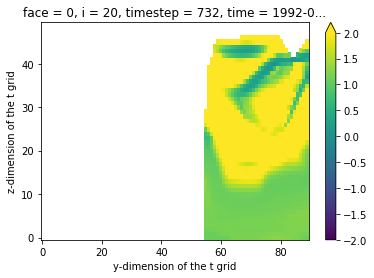

In [91]:
b.isel(face=0,i=20).plot(vmax=2,vmin=-2)

<ipython-input-55-08d7ea99cc74>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(ds['geolat'].sel(select,method='nearest'),


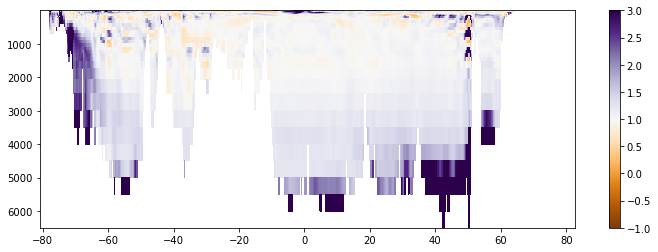

In [55]:
select = {'xh':-180}
fig,ax = plt.subplots(figsize=(12,4))
im = ax.pcolormesh(ds['geolat'].sel(select,method='nearest'),
                   ds['z_l'],
                   b.sel(select,method='nearest').transpose(),
                   vmin=-1,vmax=3,cmap='PuOr')
plt.colorbar(im,ax=ax)
ax.invert_yaxis()

<ipython-input-51-927c4415ce7f>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(ds['geolat'].sel(select,method='nearest'),


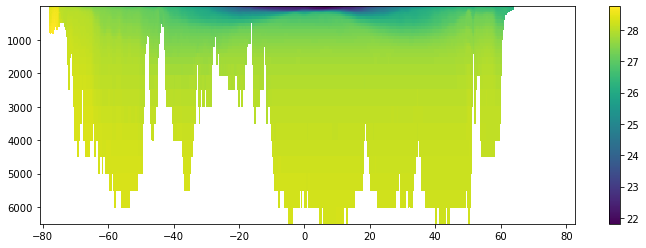

In [51]:
select = {'xh':-180}
fig,ax = plt.subplots(figsize=(12,4))
im = ax.pcolormesh(ds['geolat'].sel(select,method='nearest'),
           ds['z_l'],
           ds['g'].sel(select,method='nearest').transpose())
ax.invert_yaxis()
plt.colorbar(im,ax=ax)